In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
ratings = pd.read_csv("drive/MyDrive/Dataset2/General Result/ratings.csv")
movies = pd.read_csv("drive/MyDrive/Dataset2/General Result/Movies.csv")

In [19]:
movies_ratings = pd.merge(ratings, movies, on="movieId")

In [20]:
movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,3,4.0,964981247,Shadows in Paradise,"Drama,Comedy,Romance"
1,6,3,5.0,845554296,Shadows in Paradise,"Drama,Comedy,Romance"
2,19,3,3.0,965707636,Shadows in Paradise,"Drama,Comedy,Romance"
3,32,3,3.0,856736172,Shadows in Paradise,"Drama,Comedy,Romance"
4,42,3,4.0,996221045,Shadows in Paradise,"Drama,Comedy,Romance"


In [21]:
movies_ratings = movies_ratings[['userId', 'movieId', 'genres', 'rating']]

In [22]:
movies_ratings.head()

,userId,movieId,genres,rating
0,1,3,"Drama,Comedy,Romance",4.0
1,6,3,"Drama,Comedy,Romance",5.0
2,19,3,"Drama,Comedy,Romance",3.0
3,32,3,"Drama,Comedy,Romance",3.0
4,42,3,"Drama,Comedy,Romance",4.0


In [23]:
movies_ratings = movies_ratings.sort_values(by='userId', ascending=True)

In [24]:
movies_ratings.head()

,userId,movieId,genres,rating
0,1,3,"Drama,Comedy,Romance",4.0
2996,1,1580,"Thriller,Crime,Drama",3.0
3161,1,1587,"Romance,Drama",5.0
3192,1,1644,"Thriller,Drama,Mystery,Horror",3.0
3224,1,1927,"Science Fiction,Adventure,Action",5.0


In [25]:
movies_ratings['genres'] = movies_ratings['genres'].str.split(',')
movies_ratings.head()

,userId,movieId,genres,rating
0,1,3,"[Drama, Comedy, Romance]",4.0
2996,1,1580,"[Thriller, Crime, Drama]",3.0
3161,1,1587,"[Romance, Drama]",5.0
3192,1,1644,"[Thriller, Drama, Mystery, Horror]",3.0
3224,1,1927,"[Science Fiction, Adventure, Action]",5.0


In [26]:
n_movies = movies_ratings['movieId'].nunique()
n_users = movies_ratings['userId'].nunique()

print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of unique movieId's: 862
Number of unique users: 604


In [27]:
movie_stats = ratings.groupby('userId')['movieId'].agg(['count'])
movie_stats.head()

,count
userId,
1,232
2,29
3,39
4,216
5,44


In [28]:
# قم بتحويل البيانات إلى قاموس
user_movie_dict = {}

for user_id, count_for_user in movie_stats.iterrows():
    user_movie_dict[user_id] = count_for_user['count']


In [29]:
# تفجير القائمة في عمود 'genres'
exploded_ratings = movies_ratings.explode('genres')

# استخدام groupby لتجميع البيانات بناءً على 'userId' و 'genres'، ثم حساب حجم كل مجموعة
user_genre_counts = exploded_ratings.groupby(['userId', 'genres']).size().reset_index(name='No.Of Frequency')

# طباعة النتائج
user_genre_counts.head()


,userId,genres,No.Of Frequency
0,1,Action,11
1,1,Adventure,9
2,1,Comedy,17
3,1,Crime,15
4,1,Drama,33


In [30]:
from collections import Counter

genre_frequency = Counter(g for genres in movies_ratings['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 19 genres.


Counter({'Drama': 9773,
         'Comedy': 4323,
         'Romance': 3583,
         'Thriller': 5853,
         'Crime': 3417,
         'Mystery': 2408,
         'Horror': 1651,
         'Science Fiction': 2364,
         'Adventure': 2966,
         'Action': 4013,
         'Music': 244,
         'TV Movie': 71,
         'War': 653,
         'Fantasy': 1574,
         'Family': 1097,
         'History': 655,
         'Animation': 352,
         'Documentary': 28,
         'Western': 185})

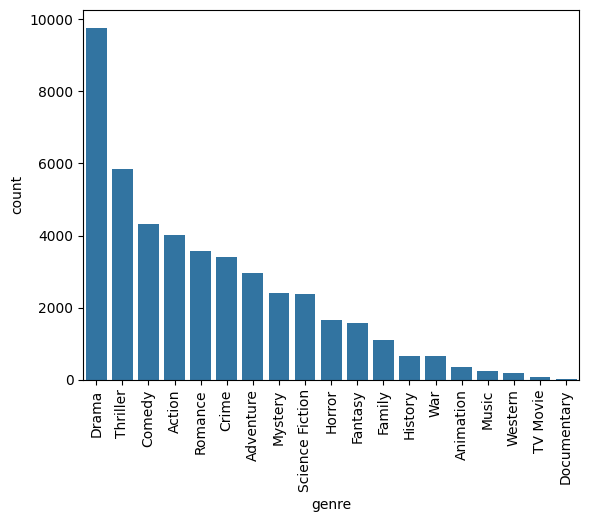

In [31]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [17]:
# # قم بتكوين القاموس لتخزين النتائج
# user_genre_dict = {}

# # قم بالتكرار على كل الـ genres الممكنة وكل المستخدمين
# for user_id, genre, number_of_times in user_genre_counts.itertuples(index=False):
#     # استخدم الزوج (user_id, genre) كمفتاح للقاموس و `No.Of Frequency` كقيمة.
#     user_genre_dict[(user_id, genre)] = number_of_times

# # طباعة النتائج في القاموس
# for (user_id, genre), number_of_times in user_genre_dict.items():
#     print(f"The No.Of Frequency for user '{user_id}' and genre '{genre}' is: [{number_of_times}]")

In [32]:
def user_behavior_probability(total_movies, genre_label_count):
    user_behavior_prob = genre_label_count / total_movies
    return round(user_behavior_prob, 3)


In [33]:
# قم بتكوين القاموس لتخزين نتائج الاحتمالات لكل تصنيف (genre) لكل مستخدم
user_genre_probabilities = []

for user_id, genre, genre_count in user_genre_counts.itertuples(index=False):
    # احتمال تصنيف المستخدم للتصنيف (genre) الحالي
    probability = user_behavior_probability(user_movie_dict[user_id], genre_count)

    # استخدم الزوج (user_id, genre) كمفتاح للقاموس والاحتمال كقيمة
    user_genre_probabilities.append({'User_ID': user_id, 'Genre': genre, 'Probability': probability})

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(user_genre_probabilities)

# استخدم pivot لتحويل البيانات إلى الشكل المطلوب
User_Behavior_Probability = results_df.pivot(index='User_ID', columns='Genre', values='Probability')

# استخدام fillna لتعويض القيم الفارغة بصفر (إذا لزم الأمر)
User_Behavior_Probability.fillna(0, inplace=True)

# ضبط إعدادات pandas لعرض جميع الصفوف والأعمدة
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

User_Behavior_Probability.head()

Genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
User_ID,,,,,,,,,,,,,,,,,,,
1,0.047,0.039,0.000,0.073,0.065,0.000,0.142,0.013,0.017,0.009,0.022,0.004,0.052,0.056,0.022,0.004,0.112,0.009,0.0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.034,0.000,0.0
3,0.077,0.051,0.026,0.026,0.026,0.000,0.205,0.000,0.051,0.000,0.000,0.000,0.026,0.103,0.103,0.000,0.077,0.000,0.0
4,0.051,0.046,0.005,0.037,0.046,0.005,0.097,0.019,0.019,0.005,0.028,0.000,0.037,0.042,0.023,0.000,0.074,0.005,0.0
5,0.114,0.023,0.000,0.068,0.091,0.000,0.295,0.000,0.045,0.000,0.023,0.000,0.068,0.091,0.045,0.000,0.114,0.000,0.0


In [34]:

# قاموس لتخزين الاحتماليات لكل مستخدم وتصنيف
user_genre_probabilities_dict = {}

# iterate over each row (user) in the pivot_results DataFrame
for user_id, row in User_Behavior_Probability.iterrows():
    # iterate over each column (genre) in the row
    for genre_name, user_genre_probability in row.items():
        # تخزين الاحتمالية في القاموس
        user_genre_probabilities_dict[(user_id, genre_name)] = user_genre_probability

# إنشاء DataFrame لتخزين متوسط احتماليات كل مستخدم
user_mean_df = pd.DataFrame(index=User_Behavior_Probability.index, columns=['Mean_Probability'])

# حساب متوسط احتماليات كل مستخدم وتخزينه في DataFrame
for user_id in User_Behavior_Probability.index:
    user_probabilities = [user_genre_probabilities_dict[(user_id, genre_name)] for genre_name in User_Behavior_Probability.columns]
    mean_probability = np.mean(user_probabilities)

    # تخزين النتيجة في DataFrame
    user_mean_df.loc[user_id] = [mean_probability]

# طباعة DataFrame النتائج
user_mean_df.head()

,Mean_Probability
User_ID,
1,0.036105
2,0.003579
3,0.040579
4,0.028368
5,0.051421


In [35]:
# 1

# قاموس لتخزين الاحتماليات لكل مستخدم وتصنيف
user_genre_probabilities_dict = {}

# iterate over each row (user) in the pivot_results DataFrame
for user_id, row in User_Behavior_Probability.iterrows():
    # iterate over each column (genre) in the row
    for genre_name, user_genre_probability in row.items():
        # تخزين الاحتمالية في القاموس
        user_genre_probabilities_dict[(user_id, genre_name)] = user_genre_probability

# إنشاء DataFrame لتخزين متوسط احتماليات كل مستخدم
PCC_Probability = pd.DataFrame(index=User_Behavior_Probability.index, columns=User_Behavior_Probability.index)

# حساب متوسط احتماليات كل مستخدم وتخزينه في DataFrame
for user_id1 in User_Behavior_Probability.index:
    for user_id2 in User_Behavior_Probability.index:
        # استخدام معادلة معامل بيرسون لحساب الشبه بين المستخدمين
        user1_probabilities = [user_genre_probabilities_dict[(user_id1, genre_name)] for genre_name in User_Behavior_Probability.columns]
        user2_probabilities = [user_genre_probabilities_dict[(user_id2, genre_name)] for genre_name in User_Behavior_Probability.columns]

        U1_mean = np.mean(user1_probabilities)
        U2_mean = np.mean(user2_probabilities)

        numerator = np.sum((np.array(user1_probabilities) - U1_mean) * (np.array(user2_probabilities) - U2_mean))
        denominator_U1 = np.sqrt(np.sum((np.array(user1_probabilities) - U1_mean)**2))
        denominator_U2 = np.sqrt(np.sum((np.array(user2_probabilities) - U2_mean)**2))

        PCC_UV = numerator / (denominator_U1 * denominator_U2)

        # تخزين النتيجة في DataFrame
        PCC_Probability.loc[user_id1, user_id2] = PCC_UV

# طباعة DataFrame النتائج
PCC_Probability.head()

User_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
User_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.802394,0.761897,0.957803,0.914516,0.946461,0.909773,0.915238,0.718569,0.897702,0.934093,0.737584,0.54077,0.945547,0.865795,0.824897,0.942376,0.937374,0.943606,0.924027,0.975463,0.75413,0.87124,0.879145,0.853125,0.89154,0.90962,0.969998,0.89552,0.80166,0.813997,0.911551,0.964148,0.913501,0.879903,0.923653,0.947481,0.954374,0.93802,0.926793,0.883785,0.941722,0.931007,0.870159,0.948153,0.893853,0.88691,0.458121,0.80885,0.806124,0.938804,0.873694,0.833322,0.943137,0.645439,0.790362,0.93978,0.952002,0.90215,0.853255,0.811795,0.945291,0.942497,0.972504,0.835636,0.962173,0.862903,0.963576,0.898873,0.892381,0.678738,0.966616,0.802744,0.809235,0.782144,0.92222,0.284868,0.940904,0.901757,0.875533,0.950124,0.981401,0.898804,0.947057,0.528047,0.799999,0.170523,0.772729,0.885087,0.803928,0.967062,0.038843,0.884019,0.877088,0.857108,0.831584,0.599633,0.625475,0.88958,0.901268,0.825301,0.977654,0.952104,0.946394,0.94814,0.812373,0.882009,0.772485,0.91296,0.904926,0.942429,0.942017,0.908189,0.537276,0.893028,0.859507,0.893881,0.787974,0.830501,0.683832,0.926187,0.

In [36]:
# البيانات الأصلية
df = pd.DataFrame(movies_ratings)

# قائمة بالمستخدمين الفريدة
users = df['userId'].unique()

# إعداد الجدول
common_data = []

# حلقة لبناء البيانات
for user1 in users:
    row_data = []
    for user2 in users:
        if user1 == user2:
            # عندما يكون المستخدم هو نفسه، يمكنك تعيين قيمة معينة (مثل 0) أو تركها فارغة
            row_data.append(None)
        else:
            pair = tuple(sorted([user1, user2]))
            common_movies = len(pd.merge(df[df['userId'] == user1]['movieId'], df[df['userId'] == user2]['movieId'], on='movieId'))
            row_data.append(common_movies)

    common_data.append(row_data)
# تحويل البيانات إلى DataFrame وتعديل القيم NaN إلى 0
common_m = pd.DataFrame(common_data, index=users, columns=users).fillna(1)
common_m.head()


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
1,1.0,0.0,2.0,11.0,6.0,15.0,3.0,8.0,2.0,1.0,6.0,2.0,0.0,6.0,4.0,4.0,10.0,19.0,32.0,7.0,7.0,1.0,5.0,8.0,2.0,3.0,7.0,17.0,4.0,1.0,3.0,6.0,9.0,5.0,4.0,3.0,6.0,9.0,11.0,10.0,6.0,22.0,11.0,3.0,25.0,5.0,6.0,2.0,2.0,7.0,9.0,0.0,1.0,6.0,1.0,5.0,28.0,12.0,7.0,0.0,4.0,8.0,12.0,35.0,1.0,19.0,3.0,42.0,3.0,1.0,1.0,4.0,2.0,2.0,5.0,7.0,0.0,3.0,5.0,2.0,5.0,13.0,4.0,16.0,0.0,4.0,0.0,2.0,5.0,1.0,35.0,0.0,12.0,7.0,8.0,6.0,1.0,0.0,4.0,16.0,3.0,11.0,16.0,10.0,9.0,1.0,4.0,1.0,13.0,4.0,6.0,4.0,5.0,1.0,10.0,7.0,13.0,4.0,3.0,1.0,7.0,12.0,1.0,6.0,5.0,7.0,0.0,4.0,5.0,5.0,5.0,13.0,6.0,7.0,21.0,9.0,8.0,0.0,0.0,23.0,9.0,5.0,1.0,11.0,4.0,0.0,5.0,1.0,3.0,3.0,2.0,8.0,1.0,5.0,18.0,0.0,0.0,3.0,22.0,2.0,3.0,0.0,5.0,4.0,10.0,12.0,7.0,10.0,7.0,9.0,3.0,4.0,6.0,0.0,7.0,26.0,7.0,8.0,1.0,11.0,32.0,6.0,0.0,2.0,10.0,12.0,0.0,1.0,0.0,5.0,3.0,1.0,3.0,11.0,4.0,7.0,12.0,16.0,13.0,8.0,26.0,4.0,3.0,1.0,0.0,4.0,1.0,2.0,4.0,6.0,1.0,1.0,5.0,4.0,34.0,2.0,21.0,15.0,13.0,10.0,5.0,2.0,2.0,24.0,3.0,0.0,6.0,9.0,1.0,15.0,5.0,20.0,8.0,2.0,2.0,2.0,21.0,12.0,3.0,5.0,1.0,10.0,1.0,5.0,10.0,1.0,20.0,2.0,3.0,1.0,0.0,9.0,1.0,1.0,1.0,0.0,0.0,6.0,4.0,2.0,10.0,4.0,10.0,16.0,2.0,7.0,3.0,3.0,0.0,1.0,7.0,37.0,12.0,1.0,1.0,0.0,5.0,8.0,0.0,18.0,4.0,9.0,1.0,7.0,9.0,41.0,2.0,11.0,18.0,0.0,27.0,3.0,3.0,5.0,16.0,0.0,1.0,8.0,4.0,2.0,17.0,22.0,0.0,30.0,7.0,6.0,1.0,1.0,14.0,26.0,10.0,0.0,3.0,9.0,22.0,1.0,0.0,5.0,8.0,9.0,0.0,9.0,3.0,4.0,17.0,0.0,23.0,2.0,10.0,0.0,5.0,4.0,7.0,5.0,1.0,10.0,5.0,1.0,2.0,3.0,4.0,1.0,3.0,6.0,3.0,4.0,1.0,2.0,7.0,10.0,18.0,1.0,13.0,17.0,0.0,6.0,0.0,6.0,7.0,2.0,1.0,3.0,3.0,6.0,27.0,4.0,5.0,3.0,18.0,11.0,6.0,2.0,7.0,2.0,1.0,6.0,30.0,16.0,5.0,0.0,6.0,17.0,8.0,37.0,0.0,1.0,5.0,23.0,1.0,3.0,5.0,8.0,1.0,0.0,2.0,3.0,3.0,2.0,3.

In [37]:
# 2
# تعريف القانون
def custom_function(value):
    if 0 <= value <= 5:
        return np.exp(-(5 - value))
    elif value > 5:
        return np.log(value - 5) + 1
    else:
        return 1

In [38]:
CONFIDENCE_COEFFICIENT = pd.DataFrame(common_data, index=users, columns=users).applymap(custom_function)
CONFIDENCE_COEFFICIENT.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
1,1.000000,0.006738,0.049787,2.791759,1.000000,3.302585,0.135335,2.098612,0.049787,0.018316,1.000000,0.049787,0.006738,1.000000,0.367879,0.367879,2.609438,3.639057,4.295837,1.693147,1.693147,0.018316,1.000000,2.098612,0.049787,0.135335,1.693147,3.484907,0.367879,0.018316,0.135335,1.000000,2.386294,1.000000,0.367879,0.135335,1.000000,2.386294,2.791759,2.609438,1.000000,3.833213,2.791759,0.135335,3.995732,1.000000,1.000000,0.049787,0.049787,1.693147,2.386294,0.006738,0.018316,1.000000,0.018316,1.000000,4.135494,2.945910,1.693147,0.006738,0.367879,2.098612,2.945910,4.401197,0.018316,3.639057,0.135335,4.610918,0.135335,0.018316,0.018316,0.367879,0.049787,0.049787,1.000000,1.693147,0.006738,0.135335,1.000000,0.049787,1.000000,3.079442,0.367879,3.397895,0.006738,0.367879,0.006738,0.049787,1.000000,0.018316,4.401197,0.006738,2.945910,1.693147,2.098612,1.000000,0.018316,0.006738,0.367879,3.397895,0.135335,2.791759,3.397895,2.609438,2.386294,0.018316,0.367879,0.018316,3.079442,0.367879,1.000000,0.367879,1.000000,0.018316,2.609438,1.693147,3.079442,0.367879,0.135335,0.018316,1.693147,2.945910,0.018316,1.000000,1.000000,1.693147,0.006738,0.367879,1.000000,1.000000,1.000000,3.079442,1.000000,1.693147,3.772589,2.386294,2.098612,0.006738,0.006738,3.890372,2.386294,1.000000,0.018316,2.791759,0.367879,0.006738,1.000000,0.018316,0.135335,0.135335,0.049787,2.098612,0.018316,1.000000,3.564949,0.006738,0.006738,0.135335,3.833213,0.049787,0.135335,0.006738,1.000000,0.367879,2.609438,2.945910,1.693147,2.609438,1.693147,2.386294,0.135335,0.367879,1.000000,0.006738,1.693147,4.044522,1.693147,2.098612,0.018316,2.791759,4.295837,1.000000,0.006738,0.049787,2.609438,2.945910,0.006738,0.0183

In [39]:
# 3

# تحويل البيانات إلى DataFrame
df = pd.DataFrame(movies_ratings)

# قائمة بالمستخدمين الفريدة
users = df['userId'].unique()

# إعداد الجدول
rate_user = []

# حلقة لبناء البيانات
for user in users:
    row_data = []
    for movie in df['movieId'].unique():
        rating = df[(df['userId'] == user) & (df['movieId'] == movie)]['rating'].values
        if len(rating) > 0:
            row_data.append(rating[0])
        else:
            row_data.append(None)

    rate_user.append(row_data)

# تحويل البيانات إلى DataFrame
table_rate = pd.DataFrame(rate_user, index=users, columns=df['movieId'].unique()).fillna(0)

# قاموس لتخزين الاحتماليات لكل مستخدم وتصنيف
rate_dict = {}

# iterate over each row (user) in the table_rate DataFrame
for user_id, row in table_rate.iterrows():
    # iterate over each column (movie) in the row
    for movie_id, user_movie_rating in row.items():
        # تخزين التقييم في القاموس
        rate_dict[(user_id, movie_id)] = user_movie_rating

# إنشاء DataFrame لتخزين متوسط احتماليات كل مستخدم
PCC_Rating = pd.DataFrame(index=table_rate.index, columns=table_rate.index)

# حساب متوسط احتماليات كل مستخدم وتخزينه في DataFrame
for user_id1 in table_rate.index:
    for user_id2 in table_rate.index:
        # استخدام معادلة معامل بيرسون لحساب الشبه بين المستخدمين
        user1_ratings = [rate_dict[(user_id1, movie_id)] for movie_id in table_rate.columns]
        user2_ratings = [rate_dict[(user_id2, movie_id)] for movie_id in table_rate.columns]

        U1_mean = np.mean(user1_ratings)
        U2_mean = np.mean(user2_ratings)

        numerator = np.sum((np.array(user1_ratings) - U1_mean) * (np.array(user2_ratings) - U2_mean))
        denominator_U1 = np.sqrt(np.sum((np.array(user1_ratings) - U1_mean)**2))
        denominator_U2 = np.sqrt(np.sum((np.array(user2_ratings) - U2_mean)**2))

        PCC_UV = numerator / (denominator_U1 * denominator_U2)

        # تخزين النتيجة في DataFrame
        PCC_Rating.loc[user_id1, user_id2] = PCC_UV

# طباعة DataFrame النتائج
PCC_Rating.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
1,1.0,-0.009162,0.07033,0.121506,0.153217,0.09261,0.034957,0.156231,0.073563,-0.021324,0.155256,0.045945,-0.020145,0.135594,0.07567,0.103277,0.264441,0.269668,0.226118,0.135582,0.082164,0.027092,0.127458,0.203794,0.179941,0.131667,0.129584,0.198396,0.094481,0.074342,0.084232,0.079811,0.096627,0.090142,0.129242,0.046607,0.209013,0.136378,0.26021,0.118641,0.098618,0.209825,0.13212,0.044516,0.240465,0.121425,0.077921,0.041984,0.129412,0.128384,0.062845,-0.030428,0.040648,0.131842,0.028253,0.131553,0.273458,0.16727,0.099078,-0.022053,0.167341,0.115419,0.209622,0.385537,0.05544,0.253975,0.090372,0.326907,0.096579,0.013662,0.007084,0.136916,0.065192,0.021634,0.073722,0.250154,-0.009162,0.058703,0.165975,0.044772,0.133318,0.206789,0.092955,0.122219,-0.027447,0.147238,-0.018324,0.061275,0.041747,-0.007674,0.359582,-0.015807,0.207712,0.156342,0.152768,0.125097,0.02988,-0.022091,0.086097,0.236863,0.134375,0.236416,0.255882,0.109421,0.104295,0.028352,0.077658,0.021066,0.188591,0.105401,0.018712,0.086092,0.064487,0.103215,0.18498,0.134535,0.145066,0.168457,0.065019,0.003282,0.138231,0.222858,0.029449,0.181628,0.112801,0.125013,-0.015328,0.170053,0.144157,0.146746,0.147931,0.118113,0.151777,0.192848,0.249354,0.099676,0.132149,-0.015336,-0.025546,0.194603,0.182697,0.12277,0.013701,0.209921,0.102565,-0.018089,0.158571,-0.012325,0.082233,0.034569,0.074532,0.107166,0.083387,0.125587,0.164135,-0.012712,-0.017983,0.039475,0.212065,0.047812,0.027949,-0.017864,0.22829,0.116526,0.176957,0.207954,0.214489,0.131265,0.124418,0.162446,0.102793,0.071165,0.128066,-0.016377,0.188174,0.20402,0.174284,0.143778,0.134791,0.111174,0.202529,0.167392,-0.012964,0.039998,0.122462,0.160445,-0.027353,0

In [40]:
result_matrix = CONFIDENCE_COEFFICIENT * PCC_Probability * PCC_Rating

Similarity_Users_Final = pd.DataFrame(result_matrix)
Similarity_Users_Final.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
1,1.0,-0.00005,0.002668,0.3249,0.14012,0.289479,0.004304,0.300077,0.002632,-0.000351,0.145023,0.001687,-0.000073,0.128211,0.024101,0.031341,0.65028,0.919881,0.916586,0.21212,0.135703,0.000374,0.111047,0.375998,0.007643,0.015887,0.199576,0.670647,0.031126,0.001092,0.009279,0.072752,0.222313,0.082345,0.041835,0.005826,0.198036,0.31059,0.681418,0.286923,0.087157,0.757432,0.3434,0.005242,0.911018,0.108536,0.069109,0.000958,0.005211,0.175229,0.14079,-0.000179,0.00062,0.124345,0.000334,0.103975,1.062782,0.469109,0.151339,-0.000127,0.049975,0.228968,0.582018,1.650169,0.000849,0.88927,0.010554,1.452438,0.011749,0.000223,0.000088,0.048687,0.002605,0.000872,0.057661,0.390605,-0.000018,0.007475,0.14967,0.001952,0.126668,0.624952,0.030736,0.3933,-0.000098,0.043333,-0.000021,0.002357,0.03695,-0.000113,1.530463,-0.000004,0.540933,0.232174,0.27479,0.104029,0.000328,-0.000093,0.028176,0.725374,0.015009,0.645268,0.827816,0.270221,0.235971,0.000422,0.025198,0.000298,0.530207,0.035088,0.017634,0.029835,0.058566,0.001016,0.431059,0.195785,0.399316,0.048832,0.007308,0.000041,0.21677,0.627426,0.000434,0.15234,0.097473,0.199726,-0.000078,0.045116,0.114602,0.13592,0.142328,0.346014,0.134344,0.297347,0.92784,0.208093,0.265622,-0.000034,-0.000148,0.715289,0.420155,0.116232,0.000226,0.562667,0.034282,-0.000052,0.129959,-0.000163,0.008555,0.003815,0.003404,0.197055,0.001195,0.107781,0.514107,-0.000033,-0.000067,0.004674,0.751224,0.002091,0.003426,-0.000043,0.179225,0.037921,0.432724,0.601661,0.308975,0.328195,0.202419,0.360219,0.01163,0.022529,0.118044,-0.00006,0.298147,0.792926,0.255715,0.275153,0.001675,0.278028,0.832403,0.149639,-0.000032,0.001349,0.286349,0.456029,-0.000112,0.000902,-0.